# PyTorch Regression Tutorial

This tutorial demonstrates a simple linear regression using PyTorch.
We'll predict house prices using the California Housing dataset.

**Learning Objectives:**
- Understand basic PyTorch workflow
- Build a simple neural network for regression
- Train and evaluate the model
- Visualize results

## 1. Import Libraries

Import necessary libraries for data processing, model building, and visualization.

In [23]:
# 다운로드 되지 않은 라이브러리 인스톨
pip install kagglehub
pip install sympy==1.13.3 --force-reinstall

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nikhil7280/student-performance-multiple-linear-regression")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'student-performance-multiple-linear-regression' dataset.
Path to dataset files: /kaggle/input/student-performance-multiple-linear-regression


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
# from sklearn.datasets import fetch_california_housing 사용 안하므로 해제
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.8.0+cu126


# 2. pandas로 데이터 불러오기
-----
추가한 부분

In [4]:
import os
import pandas as pd

# dataset_path 아래 있는 csv 파일 하나 고르기
csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]
print(csv_files)

data = os.path.join(path, csv_files[0])  # 첫 번째 csv 사용
df = pd.read_csv(data)
# Yes, No 로 표현되어 학습이 불가능 -> 0,1로 변환
df["Extracurricular Activities"] = df["Extracurricular Activities"].map({"Yes": 1, "No": 0})

print(df.head())
print(df.info())

['Student_Performance.csv']
   Hours Studied  Previous Scores  Extracurricular Activities  Sleep Hours  \
0              7               99                           1            9   
1              4               82                           0            4   
2              8               51                           1            7   
3              5               52                           1            5   
4              7               75                           0            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3                                 2               36.0  
4                                 5               66.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count 

In [5]:
print(df.columns) # 데이터셋 columns 확인 - 범주형 -> 숫자형 데이터 변환 및 타겟 칼럼 지정 목적

Index(['Hours Studied', 'Previous Scores', 'Extracurricular Activities',
       'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index'],
      dtype='object')


## 2. Load and Explore Data

Load the California Housing dataset and explore its structure.

In [6]:
# Extract features and target
target_col = "Performance Index"  # 데이터셋에 맞게 바꾸기
X = df.drop(columns=[target_col])
y = df[target_col]

In [7]:
# feature 추출해서 list 형태로 저장

data_features = df.columns.tolist()
print(data_features)

['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']


In [8]:
# Load California Housing dataset
# data = fetch_california_housing() 사용하지 않는 파일



print("Dataset Information:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"\nFeature names: {data_features }")
print(f"Target: Median Performance")

# Display statistics
print(f"\nTarget statistics:")
print(f"  Min: {y.min() }")
print(f"  Max: {y.max() }")
print(f"  Mean: {y.mean()}")

Dataset Information:
Number of samples: 10000
Number of features: 5

Feature names: ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']
Target: Median Performance

Target statistics:
  Min: 10.0
  Max: 100.0
  Mean: 55.2248


## 3. Data Preprocessing

Split the data into training and test sets, and normalize features for better training performance.

In [24]:
# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42 # 70%는 학습에 사용, 30%만 추측에 사용
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Normalize features using StandardScaler
# This helps neural networks train faster and more stably

scaler = StandardScaler() # 표준화 해주는 방법  모델 성능 높일 때 이런 파라미터들 하나씩 조정해 주면 됨
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data normalized (mean=0, std=1)") # 표준화 되었기 때문에, 0, 1로 나옴

Training set size: 7000 samples
Test set size: 3000 samples

✓ Data normalized (mean=0, std=1)


## 4. Convert to PyTorch Tensors

Convert NumPy arrays to PyTorch tensors and create DataLoaders for batch processing.

In [25]:
# y_train은 pandas Series라서
# torch.FloatTensor(y_train)이 어떤 환경에서는 모양을 제대로 못 잡고 에러
#   --> y_train.to_numpy() / y_train.values 로 명시적으로 numpy array로 바꾼 뒤
#       torch.tensor(..., dtype=torch.float32) 하는 게 가장 안전

# 디버깅용
y = df["Performance Index"]
print(y.head())
print(y.dtype)



0    91.0
1    65.0
2    45.0
3    36.0
4    66.0
Name: Performance Index, dtype: float64
float64


기록용 : <br>
pandas Series란?  = 값(value) + 인덱스(index)로 이루어진 1차원 배열

getattr(객체, "속성", 기본값) <br>
→ 객체에 "속성"이 있으면 그 값을 사용 <br>
→ 없으면 기본값을 사용

✔ A. X_train_scaled가 pandas DataFrame이면?

DataFrame은 .values 속성이 있음 → numpy 배열로 추출됨  

X_train_scaled.values << Output: numpy array 형태

In [26]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(
    getattr(X_train_scaled, "values", X_train_scaled),  # DF면 .values, 이미 numpy면 그대로
    dtype=torch.float32
)
X_test_tensor = torch.tensor(
    getattr(X_test_scaled, "values", X_test_scaled),
    dtype=torch.float32
)

# y는 Series니까 .values 또는 .to_numpy()로 변환 후 텐서로
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
y_test_tensor  = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)


# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for batch processing
batch_size = 64 # 컴퓨터 사양이 안좋다면 batch size 를 32, 16, 8, 4 이렇게 가능 batch_size는 학습 시간** 에 영향 주니까 < 사양에 맞추기
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Batch size: 64
Number of training batches: 110
Number of test batches: 47


## 5. Model Definition

Define a simple feedforward neural network for regression.

**Architecture:**
- Input layer: 8 features
- Hidden layer 1: 64 neurons with ReLU activation
- Hidden layer 2: 32 neurons with ReLU activation < 유의미한 내용들 활용해야 하니까
- Output layer: 1 neuron (predicted house price) < 가격값 예측 해야 하니까 1 뉴런으로

In [39]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32):
        super(RegressionModel, self).__init__()

        # Define layers 레이어 정의
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)  # Output layer

    # 이 순서로 신경망을 거칠 거야. 정의
    # pytorch 쓸 때, 나중에 재활용하는 경우도 있으므로, 1) 모델을 정의한 후에 2) 그 후에 활용함. 위쪽


    def forward(self, x):
        # Forward pass through the network
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Initialize model << 모델 초기화 안해주면 여러번 실행했을 때, 이전에 학습한 모델의 가중치가 그대로 남아 있음
#                     따라서 꼭 활용하자! 지금은 랜덤으로 정의돼 있지만, 추후 사용 시 사전 초기화된 내용 활용 가능
input_size = X_train_scaled.shape[1]  # Number of features (8)
model = RegressionModel(input_size).to(device)

print(model) # 모델 출력 여기서 사용하는 모델은 깊은 모델이 아니므로 이렇게 확인
print(f"\nModel moved to: {device}")

RegressionModel(
  (fc1): Linear(in_features=5, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Model moved to: cuda


## 6. Loss Function and Optimizer

Define the loss function and optimizer for training.

- **Loss Function:** Mean Squared Error (MSE) - standard for regression
- **Optimizer:** Adam - adaptive learning rate optimizer

In [40]:
# Loss function: Mean Squared Error
criterion = nn.MSELoss() # 에러가 얼마나 큰지를 반영 간단한 회귀 문제에서 자주 사용하는 loss function

# Optimizer: Adam with learning rate 0.001
learning_rate = 0.001 # 0.001 이 기본 옵션.
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # 어떤거 썼는지 정도만 확인할 수 있으면 된다.

print(f"Loss function: {criterion}")
print(f"Optimizer: Adam")
print(f"Learning rate: {learning_rate}")

Loss function: MSELoss()
Optimizer: Adam
Learning rate: 0.001


## 7. Training Loop

Train the model and track the loss over epochs.

**Training Process:**
1. Forward pass: compute predictions
2. Compute loss: compare predictions with true values
3. Backward pass: compute gradients
4. Update weights: optimize parameters

In [41]:
# Training parameters
num_epochs = 20 # 이거 횟수 늘리면 정확도 높아짐.

# Track losses for visualization 계산된 loss 값을 저장해 줘야 함.
# why? 저장해 줘야 과적합인지 underfitting 인지 확인할 수 있으므로
train_losses = []
test_losses = []

print("Starting training...")
print("-" * 60)


# 모델 epoch 만큼 모델을 트레이닝을 하는 것.
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Move data to device (GPU if available) cuda 한테 넘김
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # 1. Forward pass: compute predictions
        predictions = model(X_batch)

        # 2. Compute loss
        loss = criterion(predictions, y_batch)

        # 3. Backward pass: compute gradients -- loss 값을 뒤로 넘겨서 최적의 학습 가능하게
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute new gradients

        # 4. Update weights
        optimizer.step()

        train_loss += loss.item() # 로스 값을 더해주면서 저장해 주기.

    # Average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation phase (no gradient computation needed)
    model.eval() # evaluation
    test_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Test Loss: {avg_test_loss:.4f}")

print("-" * 60)
print("Training complete!")

Starting training...
------------------------------------------------------------
Epoch [10/20] | Train Loss: 13.5886 | Test Loss: 13.0748
Epoch [20/20] | Train Loss: 4.5574 | Test Loss: 4.5649
------------------------------------------------------------
Training complete!


## 8. Visualize Training Progress

Plot the training and test losses to see how the model learned over time.

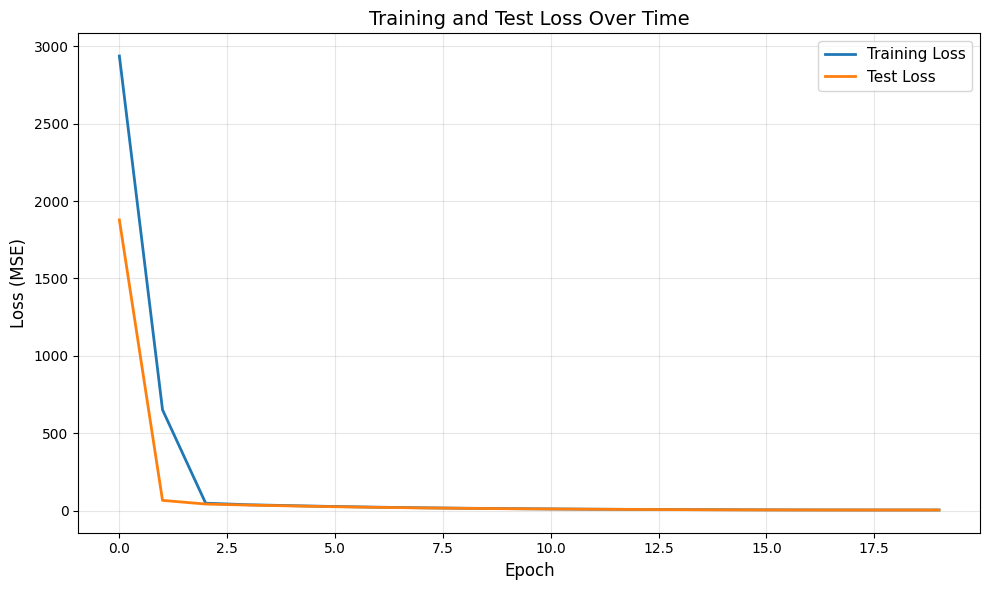

Final Training Loss: 4.5574
Final Test Loss: 4.5649


In [42]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Test Loss Over Time', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

# 파란색 선 train loss
# 주황색이 test loss

## 9. Model Evaluation

Evaluate the model on the test set and visualize predictions vs actual values.

In [43]:
# Make predictions on test set
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_pred = model(X_test_device).cpu().numpy()
    y_true = y_test_tensor.numpy()

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mse)

print("Model Performance on Test Set:")
print("=" * 50)
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print("=" * 50)
print(f"\nInterpretation:")
print(f"On average, predictions are off by {mae:.2f}")
print(f"Model explains {r2:.2f}% of the variance in performances")

# root mean squared error
# mean absolute error 차이나는 걸 절댓값으로 >> 얼마만큼 차이가 나 보여주는것
# R^2 얼마나 유사하게 예측했는가.

Model Performance on Test Set:
Mean Squared Error (MSE):  4.5672
Root Mean Squared Error (RMSE): 2.1371
Mean Absolute Error (MAE): 1.6967
R² Score: 0.9877

Interpretation:
On average, predictions are off by 1.70
Model explains 0.99% of the variance in performances


## 10. Visualize Predictions

Compare predicted values with actual values to see how well the model performs.

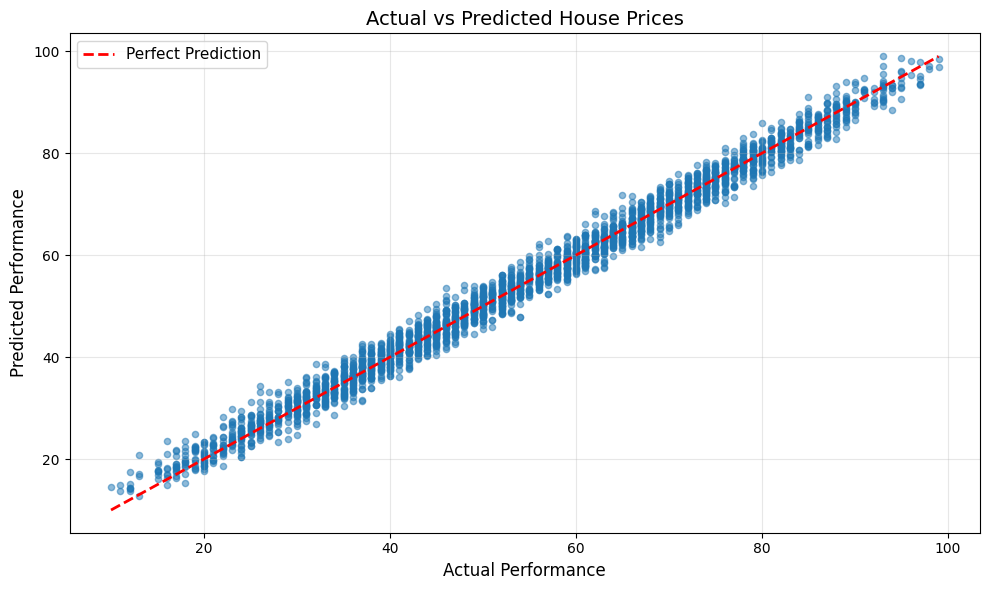


Sample Predictions (first 10 houses):
------------------------------------------------------------
      Actual |    Predicted |   Difference
------------------------------------------------------------
        51 |         54 |         -3
        20 |         23 |         -3
        46 |         48 |         -2
        28 |         30 |         -2
        41 |         43 |         -2
        59 |         59 |         -0
        48 |         47 |          1
        87 |         87 |         -0
        37 |         37 |          0
        73 |         72 |          1


In [45]:
# Create scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, s=20)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Performance', fontsize=12)
plt.ylabel('Predicted Performance', fontsize=12)
plt.title('Actual vs Predicted House Prices', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show some sample predictions
print("\nSample Predictions (first 10 houses):")
print("-" * 60)
print(f"{'Actual':>12} | {'Predicted':>12} | {'Difference':>12}")
print("-" * 60)
for i in range(min(10, len(y_true))):
    actual = y_true[i][0]
    predicted = y_pred[i][0]
    diff = actual - predicted
    print(f"{actual:>10,.0f} | {predicted:>10,.0f} | {diff:>10,.0f}")

    # 빨간 줄이 정답.
    # 빨간 줄에 가까이 있어야 좋음
    # 몰려는 있긴 한데 이상치들 >> 예측이 안되고 있음.

    # training set 비율 늘리기
    # epoch 늘리기
    # 데이터셋 추가하기

## 11. Save the Model (Optional)

Save the trained model for future use.

모델을 저장하고 난 뒤에 나중에 호출하는 것으로 활용이 가능하다.

In [46]:
# Save model
torch.save(model.state_dict(), 'house_price_model.pth') # 저장할 파일명
print("✓ Model saved to 'house_price_model.pth'")

# To load the model later:
# model = RegressionModel(input_size)
# model.load_state_dict(torch.load('house_price_model.pth'))
# model.to(device)
# model.eval()

print("\nTo load this model later, use:")
print("  model = RegressionModel(input_size)")
print("  model.load_state_dict(torch.load('house_price_model.pth'))")
print("  model.to(device)")
print("  model.eval()")

# 이거 쓰면 house_price_model.eth 가 생성. 여기에 들어가 있는거 활용하면 된다.

✓ Model saved to 'house_price_model.pth'

To load this model later, use:
  model = RegressionModel(input_size)
  model.load_state_dict(torch.load('house_price_model.pth'))
  model.to(device)
  model.eval()


## Summary

### What We Learned:

1. **Data Preparation**: Loaded, split, and normalized data
2. **PyTorch Tensors**: Converted data to PyTorch format
3. **DataLoader**: Created batches for efficient training
4. **Neural Network**: Built a simple feedforward network
5. **Training Loop**: Implemented forward/backward passes
6. **Evaluation**: Assessed model performance with metrics
7. **Visualization**: Plotted training progress and predictions

### Key Concepts:

- **Forward Pass**: Input → Hidden Layers → Output
- **Loss Function**: Measures prediction error (MSE)
- **Backward Pass**: Computes gradients via backpropagation
- **Optimizer**: Updates weights to minimize loss (Adam)
- **Epochs**: Complete passes through training data

### Next Steps:

Try experimenting with:
- Different network architectures (more/fewer layers)
- Different activation functions
- Different optimizers (SGD, RMSprop)
- Learning rate scheduling
- Dropout for regularization

# Homework
1. Kaggle에서 regression 관련 dataset을 찾아 .csv 파일 등등을 다운받고
2. 해당 dataset을 load하여 regression을 통해 최대한 높은 regression 정확도 달성해보기

In [ ]:
# 아래 이어서 코드 작성하여 결과를 포함한 .ipynb 파일을 깃허브에 커밋하여 제출하세요!

csv 파일 불러와서 사용할 수도 있음.
밑에 데이터 분포 같은것도 확인할 수 있음.

정규분포 돼있는지 도 확인이 가능함.

https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression